## Vulnerability analysis

This notebook contains analysis of vulnerabilities in Common Criteria certificates. 

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

from sec_certs.dataset.common_criteria import CCDataset
import datetime

import itertools
from sec_certs.dataset.cve import CVEDataset
from sec_certs.dataset.common_criteria import CCDatasetMaintenanceUpdates

## Retrieve necessary objects from sec-certs

In [2]:
# Local instantiation
dset: CCDataset = CCDataset.from_json('/Users/adam/phd/projects/certificates/datasets/cc_full_dataset/CommonCriteria_dataset.json')
main_dset = CCDatasetMaintenanceUpdates.from_json('/Users/adam/phd/projects/certificates/datasets/cc_full_dataset/certs/maintenance/Maintenance updates.json')
cve_dset: CVEDataset = dset._prepare_cve_dataset()

# Fully remote instantiation
# dset: CCDataset = CCDataset.from_web_latest()
# main_dset: CDatasetMaintenanceUpdates = CCDatasetMaintenanceUpdates.from_web_latest()
# cve_dset: CVEDataset = CVEDataset.from_web()

parsing cpe matching (by NIST) dictionary: 100%|██████████| 357664/357664 [00:28<00:00, 12678.12it/s]
Building-up lookup dictionaries for fast CVE matching: 100%|██████████| 172913/172913 [00:12<00:00, 13587.20it/s]


## Define some helper functions

In [23]:
def find_earliest_after_cve(row):
    "Given dataframe row, will return first maintenance date succeeding first published CVE related to a certificate if exists, else np.nan"
    if isinstance(row['earliest_cve'], float):
        return np.nan
    maintenances_after_cve = list(filter(lambda x: x > row['earliest_cve'], row['maintenance_dates']))
    return min(maintenances_after_cve) if maintenances_after_cve else np.nan

## Preprocess dataset of Common Criteria certificates

In [5]:
df = dset.to_pandas()
df = df.loc[~df.manufacturer.isnull()] # Manually delete one certificate with None manufacturer (seems to have many blank fields)

# # Introduce highest security level EAL variable
eals = ['EAL1', 'EAL1+', 'EAL2', 'EAL2+', 'EAL3', 'EAL3+', 'EAL4', 'EAL4+', 'EAL5', 'EAL5+', 'EAL6+', 'EAL7', 'EAL7+']
df['highest_security_level'] = df.security_level.map(lambda all_levels: [eal for eal in all_levels if eal.startswith('EAL')] if all_levels else np.nan)
df.highest_security_level = df.highest_security_level.map(lambda x: x[0] if x and isinstance(x, list) else np.nan)
df.highest_security_level = pd.Categorical(df.highest_security_level, categories=eals, ordered=True)

# Introduce year when cert got valid
df['year_from'] = pd.DatetimeIndex(df.not_valid_before).year

## Preprocess dataset of maintenance updates

In [6]:
main_df = main_dset.to_pandas()
main_df.maintenance_date = main_df.maintenance_date.dt.date

# Recover number of maintenances
n_maintenances = main_df.groupby('related_cert_digest').name.count()
n_maintenances.index.name = 'dgst'
n_maintenances = n_maintenances.rename('n_maintenances')

if 'n_maintenances' not in df.columns:
    df = pd.concat([df, n_maintenances], axis='columns')
    df.n_maintenances = df.n_maintenances.fillna(0).astype('int32')

# # Recover dates of maintenance updates
main_dates = main_df.copy()
main_dates.maintenance_date = main_df.maintenance_date.map(lambda x: [x])
main_dates = main_dates.groupby('related_cert_digest').maintenance_date.agg('sum').rename('maintenance_dates')
main_dates.index.name = 'dgst'

if 'maintenance_dates' not in df.columns:
    df = pd.concat([df, main_dates], axis='columns')

## Process CVE dataset and enrich CC DataFrame with CVE-related columns

In [7]:
# Build CVE dataset
cves = list(itertools.chain.from_iterable([x.heuristics.related_cves for x in dset if x.heuristics.related_cves]))
cve_dict = {x: cve_dset[x] for x in cves}
cve_dset.cves = cve_dict
cve_df = cve_dset.to_pandas()

# # Get some auxillary columns related to CVEs
df['n_cves'] = df.related_cves.map(lambda x: len(x) if x is not np.nan else 0)
df['cve_published_dates'] = df.related_cves.map(lambda x: [cve_dset[y].published_date.date() for y in x] if x is not np.nan else np.nan)
df['earliest_cve'] = df.cve_published_dates.map(lambda x: min(x) if isinstance(x, list) else np.nan)
df['worst_cve'] = df.related_cves.map(lambda x: max([cve_dset[cve].impact.base_score for cve in x]) if x is not np.nan else np.nan)

In [9]:
# Take a look at columns related to CVEs
df.loc[~df.related_cves.isna(), ['related_cves', 'cve_published_dates', 'earliest_cve', 'worst_cve']]

,related_cves,cve_published_dates,earliest_cve,worst_cve
c4bd865f2ae51533,[CVE-2019-5408],[2019-08-09],2019-08-09,6.5
b9f476ad0695d397,[CVE-2021-20740],[2021-06-28],2021-06-28,8.8
ebd276cca70fd723,"[CVE-2013-5420, CVE-2013-5421, CVE-2013-6745, ...","[2013-12-23, 2013-12-22, 2013-12-22, 2015-01-2...",2013-12-22,10.0
7a53ce3f91bf73c7,"[CVE-2017-14799, CVE-2017-14800, CVE-2017-1480...","[2018-03-01, 2018-03-01, 2018-03-02, 2018-03-0...",2018-03-01,6.1
ac5e56e41a0b950e,"[CVE-2018-13367, CVE-2019-15703, CVE-2019-1765...","[2019-08-23, 2019-10-24, 2020-06-16, 2021-04-1...",2019-08-23,9.8
...,...,...,...,...
48e7e9d2282c61b3,[CVE-2021-35469],[2021-07-14],2021-07-14,7.8
ffeef32299d913d6,"[CVE-2008-1130, CVE-2008-1592, CVE-2009-0439]","[2008-03-04, 2008-03-31, 2009-02-24]",2008-03-04,7.2
a092aebf5a286ded,[CVE-2004-2558],[2004-12-31],2004-12-31,7.5
ace069b9b7c10f19,[CVE-2000-0772],[2000-10-20],2000-10-20,7.5


## Plot distribution of categories in CPE-rich vs. all certificates

<AxesSubplot:title={'center':'Categories (without smartcards) comparison between CPE-rich, CVE-rich and all certificates'}>

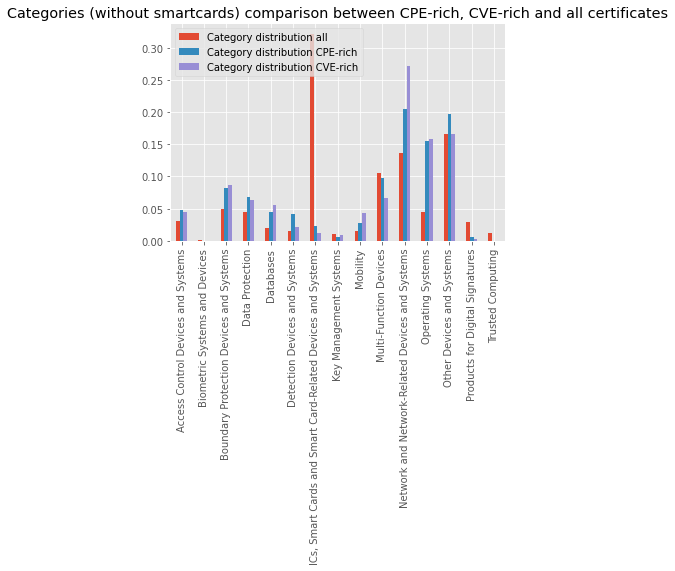

In [12]:
df_cpe_rich = df.loc[~df.verified_cpe_matches.isnull()].copy()
df_cve_rich = df.loc[df.n_cves > 0].copy()

categories_cpe = df_cpe_rich.category.value_counts().sort_index().rename('Category distribution CPE-rich')
categories_cve = df_cve_rich.category.value_counts().sort_index().rename('Category distribution CVE-rich')
categories_all = df.category.value_counts().sort_index().rename('Category distribution all')

categories_merged = pd.concat([categories_all, categories_cpe, categories_cve], axis=1)
categories_merged = categories_merged.div(categories_merged.sum(axis=0), axis=1)
categories_merged.plot.bar(title='Categories (without smartcards) comparison between CPE-rich, CVE-rich and all certificates')

## Plot distribution of years in CPE-rich, CVE-rich, and all certificates

<AxesSubplot:title={'center':'Years comparision between CPE-rich, CVE-rich and all certificates'}>

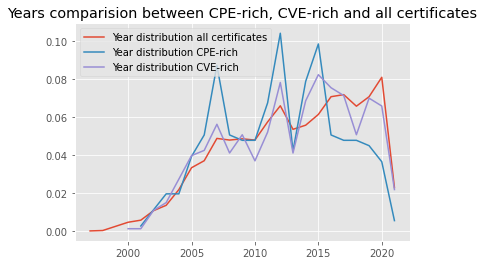

In [13]:
years_cpe = df_cpe_rich.year_from.value_counts().sort_index().rename('Year distribution CPE-rich')
years_cve = df_cve_rich.year_from.value_counts().sort_index().rename('Year distribution CVE-rich')
years_all = df.year_from.value_counts().sort_index().rename('Year distribution all certificates')

years_merged = pd.concat([years_all, years_cpe, years_cve], axis=1)
years_merged = years_merged.div(years_merged.sum(axis=0), axis=1)
years_merged.plot.line(title='Years comparision between CPE-rich, CVE-rich and all certificates')

## Plot distribution of security levels in CPE-rich, CVE-rich and all certificates

<AxesSubplot:title={'center':'Highest security level comparision between CPE-rich, CVE-rich and all certificates'}>

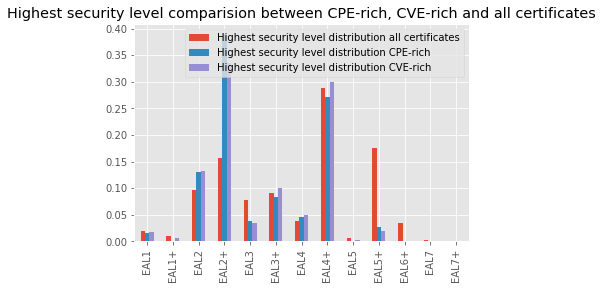

In [14]:
levels_cpe = df_cpe_rich.highest_security_level.value_counts().sort_index().rename('Highest security level distribution CPE-rich')
levels_cve = df_cve_rich.highest_security_level.value_counts().sort_index().rename('Highest security level distribution CVE-rich')
levels_all = df.highest_security_level.value_counts().sort_index().rename('Highest security level distribution all certificates')

levels_merged = pd.concat([levels_all, levels_cpe, levels_cve], axis=1)
levels_merged = levels_merged.div(levels_merged.sum(axis=0), axis=1)
levels_merged.plot.bar(title='Highest security level comparision between CPE-rich, CVE-rich and all certificates')

## Plot distribution of most common (top 20) vendors in CPE-rich, CVE-rich and all certificates

<AxesSubplot:title={'center':'Common vendors comparison between CPE-rich, CVE-rich and all certificates'}>

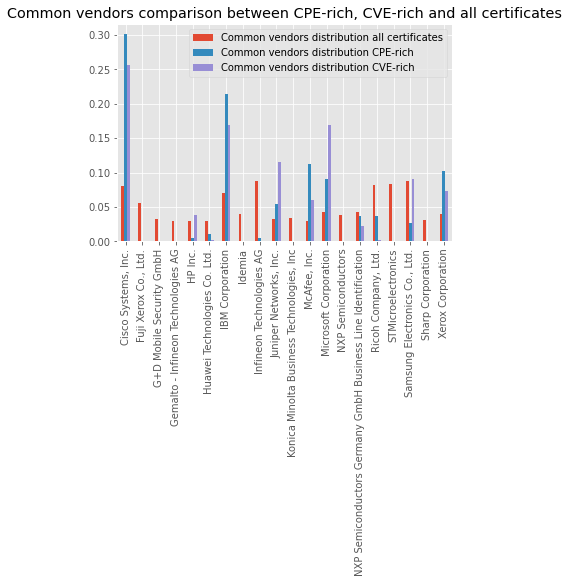

In [15]:
top_manufacturers = list(df.manufacturer.value_counts().head(20).index)
vendors_cpe = df_cpe_rich.loc[df_cpe_rich.manufacturer.isin(top_manufacturers), 'manufacturer'].value_counts().sort_index().rename('Common vendors distribution CPE-rich')
vendors_cve = df_cve_rich.loc[df_cve_rich.manufacturer.isin(top_manufacturers), 'manufacturer'].value_counts().sort_index().rename('Common vendors distribution CVE-rich')
vendors_all = df.loc[df.manufacturer.isin(top_manufacturers), 'manufacturer'].value_counts().sort_index().rename('Common vendors distribution all certificates')

vendors_merged = pd.concat([vendors_all, vendors_cpe, vendors_cve], axis=1)
vendors_merged = vendors_merged.div(vendors_merged.sum(axis=0), axis=1)
vendors_merged.plot.bar(title='Common vendors comparison between CPE-rich, CVE-rich and all certificates')

## Basic correlations between security level and CVEs

In [16]:
# Compute correlation of security level and number of cves
# Only very weak correlation found, higher level => less CVEs, definitely not conclusive, just for our information
print(f'Correlation between security level and number of CVES: {df.highest_security_level.cat.codes.corr(df.n_cves)}')
vuln_rich_df = df.loc[df.n_cves > 0]
print(f'Correlation between security level and number of CVEs (excluding vulnerability-free certs): {vuln_rich_df.highest_security_level.cat.codes.corr(vuln_rich_df.n_cves)}')

# Compute correlation of security level and the base-score of the worst CVE
print(f'Correlation between security level and the worst CVE (excluding vulnerability-free certs): {vuln_rich_df.highest_security_level.cat.codes.corr(df.worst_cve)}')

Correlation between security level and number of CVES: -0.08666305714054567
Correlation between security level and number of CVEs (excluding vulnerability-free certs): -0.08212016584434104
Correlation between security level and the worst CVE (excluding vulnerability-free certs): -0.06663087161248082


## Time from CVE to maintenance update

The following block computes time from CVE to maintenance update of a certificate. Though, it has some limitations:
- So far we only watch for first CVE related to a certified product (though most of certificates have only one maintenance anyway, if they even have one)
- We assume that a maintance update released *after* (by date comparison) CVE fixes that vulnerability
- The sample size is small. Only 36 certificates have at least one CVE and at least one Maintenance update. Out of those, only 23 certificates have maintenance update that comes after a CVE
- Some stats is shown below, the quantiles in the number of days that it takes to fix the CVE are (267, 382, 562)
- Many certificates have some CVE (167) that is not fixed in a form of a maintenance update

In [24]:
# Compute how many vulnerable certs have 0 or >0 maintenance updates
n_unfixed_certs = df.loc[(df.n_cves>0) & (df.n_maintenances==0)].shape[0]
n_fixed_certs = df.loc[(df.n_cves>0) & (df.n_maintenances>0)].shape[0]
print(f'Number of certificates with >0 CVEs but 0 maintenance reports: {n_unfixed_certs}')
print(f'Number of certificates with >0 CVEs and >0 maintenance reports: {n_fixed_certs}')

# Compute earlierst maintenance that comes after some CVE, compute time to fix
df_fixed = df.loc[(df.n_cves > 0) & (df.n_maintenances > 0)].copy()
df_fixed.loc[:, 'earliest_maintenance'] = df_fixed.apply(find_earliest_after_cve, axis=1)
df_fixed.loc[:, 'time_to_fix_cve'] = df_fixed.earliest_maintenance - df_fixed.earliest_cve

print(df_fixed.loc[~df_fixed.time_to_fix_cve.isnull()]['time_to_fix_cve'].describe())

Number of certificates with >0 CVEs but 0 maintenance reports: 626
Number of certificates with >0 CVEs and >0 maintenance reports: 104
count                              81
mean               1253 days 08:53:20
std      1288 days 15:13:54.595766064
min                  12 days 00:00:00
25%                 338 days 00:00:00
50%                 643 days 00:00:00
75%                1694 days 00:00:00
max                5161 days 00:00:00
Name: time_to_fix_cve, dtype: object


In [25]:
df_fixed.time_to_fix_cve

822d871f3bbd06d7    374 days
8a5e6bcda602920c    417 days
1675828cce75140b   2920 days
0b494b3a447bfc50   2575 days
318dcee9d8f6ac99    295 days
                      ...   
32eebb87bd1c27d6         NaT
17006cbc914ff7e1         NaT
8a3ca0abcdb5a6c3         NaT
bf0f130ebce2e124    127 days
5f1df5ad8e51ba75   2602 days
Name: time_to_fix_cve, Length: 104, dtype: timedelta64[ns]